# ODE based approximation of the Laplace transform
## Sympy automation. Skew Normal Distribution

Importing the libraries. Basic fuctions function from the previous [section](2.1.Idea%2CODE%2C%20first%20results.ipynb)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as scsp
from scipy.special import lambertw
from scipy.integrate import odeint
from IPython.display import display, Math
plt.style.use('seaborn-v0_8-darkgrid')


In [2]:
#basic functions from introduction
def LaplTrLNIntegrFuncFactory(step=5.5/512.0,n_steps=300):
    bound=(n_steps-1.0)/2.0
    t_nodes=np.arange(-bound*step,(bound+0.5)*step,step)[:,None]#symmetric integration points without 0
    sinh_t=0.5*np.pi*np.sinh(t_nodes)
    sinhsinh_t=np.sinh(sinh_t)
    sinhsinh_t2=sinhsinh_t**2
    dt_mult=0.5*np.pi*(step/np.sqrt(np.pi))*np.cosh(sinh_t)*np.cosh(t_nodes)
    max_exp=int(np.finfo(np.float64).maxexp*np.log(2.))            

    def LaplTrLN(u,v):#direct integration
        '''
        fast version of direct integration
        '''
        s=np.exp(np.sqrt(2.0*v)*sinhsinh_t)*np.atleast_1d(u)[None,:]+sinhsinh_t2
        res=np.sum(np.exp(-s)*dt_mult,axis=0)
        return res
    return LaplTrLN

LaplTrLNFastD=LaplTrLNIntegrFuncFactory()

def LaplTrLNODE2(u,v0):
    V0=1.0/v0
    def ode(V,t):return V0*np.exp(0.5/V)/V
    y=odeint(ode,V0,u).T
    return np.exp(V0-y[0])

The Normal distribution has two parameters. Let's take some known distribution with three parameters and see what happens, for example the [skew normal distribution](https://en.wikipedia.org/wiki/Skew_normal_distribution). Yet, we need  cumbersome math calculations to get the work done. To move forward, it needs to automate the calculations.

### Equations for the raw and central moments
We already have the equations for the differential of any raw moment of $Y$ 
$$dm_i=\left(M(t)m_i(t)-{}^i\!M(t)\right)S(t)dt;$$
 now we rewrite it for $du$
$$dm_i=\left(M(t)m_i(t)-{}^i\!M(t)\right)S(t)\frac{dt}{du}du =\left(M(t)m_i(t)-{}^i\!M(t)\right)du,$$
we use  (15) $S\frac{dt}{du}=1$.

Sometimes it is usefull to have equations for central moment. By the defenition
$$c_i=E[(Y-m_1)^i]=\sum_{k=0}^n(-1)^k{n \choose k}E[Y^{i-k}]m_1^k=\sum_{k=0}^n(-1)^k{n \choose k}m_{i-k}m_1^k.$$

We need to find $dc_i$.
$$c_i(u+du)=\sum_{k=0}^n(-1)^k{n \choose k}(m_{i-k}+dm_{i-k})(m_1+dm_1)^k$$
To find $dc_i$, it is sufficient to expand the last expression and take the term with $du$.

### Sympy scripts
#### Import and MGF of the Normal distribution

In [3]:
import sympy as sp
sp.init_printing()
μ,ξ,w,d,k,t,x,y,p,m,v,q,r,s,z = sp.symbols('μ,ξ,w,d,k,t,x,y,p,m,v,q,r,s,z')
normalMGF=sp.exp(z*μ + z**2*v/2)

In [4]:
print('MGF for normal distribution is')
normalMGF

MGF for normal distribution is


In [5]:
def prepend_latex(letex_str,sympy_expr):
    return Math(letex_str+sp.latex(sympy_expr))
prepend_latex('\mathcal{M}(z)=',normalMGF)

<IPython.core.display.Math object>

#### Monents

In [6]:
def RM(MGF,i): 
    '''
    symbolic function returns i-th (start from 1) raw moment: E[Y^n]
    MGF(z) - Moment-generating function
    '''
    return sp.diff(MGF,z,i).subs(z,0)

In [7]:
print('first and second raw moment for normal distribution is')
[RM(normalMGF,1),RM(normalMGF,2)]

first and second raw moment for normal distribution is


In [8]:
def RMgenerator(MGF): 
    '''
    returns symbolic function returning i-th (start from 1) 
        raw moment: E[Y^n]
    MGF(z) - Moment-generating function
    '''
    return lambda i:sp.diff(MGF,z,i).subs(z,0)

In [9]:
normal_rm=RMgenerator(normalMGF)
print('second and third raw moment for normal distribution is')
[normal_rm(2),normal_rm(3)]

second and third raw moment for normal distribution is


In [10]:
def CM(rm,i): 
    '''
    symbolic function returns i-th (start from 1) central moment: E[(Y-E[Y])^n]
    if i==1 returns 1st raw moment (1st central moment always 0) 
    rm - raw moment generator
    '''
    if i==1: return rm(1)
    x = sp.symbols('u_s')
    expr=sp.expand((x-rm(1))**i)
    for n in range(i,0,-1):
        expr=expr.subs(x**n,rm(n))
    return sp.simplify(expr)

In [11]:
print('third central moment expresson')
CM(lambda i:sp.symbols(f'm_{i}'),3)

third central moment expresson


In [12]:
print('second and third central moment for normal distribution is')
[CM(normal_rm,2),CM(normal_rm,3)]

second and third central moment for normal distribution is


In [13]:
def CMgenerator(MGF): 
    return lambda i:CM(RMgenerator(MGF),i)

In [14]:
normal_cm=CMgenerator(normalMGF)
print('third and fourth central moment for normal distribution is')
[normal_cm(3),normal_cm(4)]

third and fourth central moment for normal distribution is


#### Functions to calculate ${}^i\!M_{Y}$

In [15]:
def EM(MGF,i): 
    '''
    symbolic function returns i-th (start from 1) exp moment: E[e^Y*Y^i]
    '''
    return sp.diff(MGF,z,i).subs(z,1)

def EMgenerator(MGF): 
    return lambda i:EM(MGF,i)

${}^0\!M$ and ${}^1\!M$ for normal distribution is

In [16]:
[EM(normalMGF,0),EM(normalMGF,1)]

${}^1\!M$ and ${}^2\!M$ for normal distribution is

In [17]:
normal_em=EMgenerator(normalMGF)
[normal_em(1),normal_em(2)]

#### Derivatives
Now its time for $dm_i/du$.

In [18]:
def DRM(MGF,i):
    '''
    symbolic function returns differential of i-th (start from 1) raw moment
     '''
    if i==0:
        return -EM(MGF,0)
    return sp.simplify(RM(MGF,i)*EM(MGF,0)-EM(MGF,i))

def DRMgenerator(MGF):
    return lambda i:DRM(MGF,i)

$\frac{dm_1}{du}$ and $\frac{dm_2}{du}$ for normal distribution is

In [19]:
[DRM(normalMGF,1),DRM(normalMGF,2)]

As mentioned above to get $dc_i/du$ we need the series for $m_i(U+dU)$ first

In [20]:
dU=sp.symbols('dU')
def RMSeries(MGF,i):
    '''
    series dm_i(U+dU) up to first term 
    '''
    return sp.expand(RM(MGF,i)+DRM(MGF,i)*dU)

def RMSgenerator(MGF):# series dS(t) up to first term 
    return lambda i:RMSeries(MGF,i)

raw moments $m_1(U+dU)$ and $m_2(U+dU)$  for normal distribution is

In [21]:
[RMSeries(normalMGF,1),RMSeries(normalMGF,2)]

Next, we can get $dc_i(U+dU)$ by using CM function.

In [22]:
normal_rms=RMSgenerator(normalMGF)
display(prepend_latex('c_2(U+dU)=',CM(normal_rms,2)))
display(prepend_latex('c_3(U+dU)=',CM(normal_rms,3)))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Functions to find $dc_i/du$

In [23]:
def DCM(MGF,i):
    '''
    symbolic function returns differential of i-th central moment
    '''
    if i==0:
        return -EM(MGF,0)  
    
    expr=CM(RMSgenerator(MGF),i)
    return sp.simplify(sp.diff(expr,dU,1).subs(dU,0))

def DCMgenerator(MGF):
    return lambda i:DCM(MGF,i)

In [24]:
print('The right side for the normal distribution is')
sp.Matrix([DCM(normalMGF,0),DCM(normalMGF,1),DCM(normalMGF,2)])

The right side for the normal distribution is


⎡   v      ⎤
⎢   ─ + μ  ⎥
⎢   2      ⎥
⎢ -ℯ       ⎥
⎢          ⎥
⎢    v     ⎥
⎢    ─ + μ ⎥
⎢    2     ⎥
⎢-v⋅ℯ      ⎥
⎢          ⎥
⎢     v    ⎥
⎢     ─ + μ⎥
⎢  2  2    ⎥
⎣-v ⋅ℯ     ⎦

So for the normal distribution we get exacltly (17) as expected. 

### Equation derivation procedure example

For the normal distribution it is convinient to use second central moment dynamics. Still there is a possibility to make approximate equations using raw moments only. In this case we need to infer parameters $\nu,v$ from the moments first.

In [25]:
print('first and second raw moment for normal distribution is')
[RM(normalMGF,1),RM(normalMGF,2)]

first and second raw moment for normal distribution is


It follows: $\mu=m_1$ and $v=m_2-m_1^2$. The moments dynamic is given by right side:

In [26]:
sp.Matrix([DRM(normalMGF,0),DRM(normalMGF,1),DRM(normalMGF,2)])

⎡         v            ⎤
⎢         ─ + μ        ⎥
⎢         2            ⎥
⎢       -ℯ             ⎥
⎢                      ⎥
⎢          v           ⎥
⎢          ─ + μ       ⎥
⎢          2           ⎥
⎢      -v⋅ℯ            ⎥
⎢                      ⎥
⎢                 v    ⎥
⎢                 ─ + μ⎥
⎢⎛ 2          2⎞  2    ⎥
⎣⎝μ  - (v + μ) ⎠⋅ℯ     ⎦

And the function to approximate the Laplace transform of the lognormal distribution $\mathcal{L}_{v_0}(u)$ is 

In [27]:
modeling_period=20.0
u_step=0.02
u_r=np.arange(0.0, modeling_period+u_step, u_step,dtype=np.float64)
n_steps=len(u_r)-1
v0=0.75

In [28]:
def LaplTrLNODE3(u,v0):# u must start from 0
    def ode(y,t):
        _,mu,m2=y
        v=m2-mu**2
        dL=-np.exp(mu+0.5*v)
        dmu=v*dL
        dm2=(v+2*mu)*dmu #-(v^2+2vmu+mu^2-mu^2)M
        return [dL,dmu,dm2]
    L,_,_=odeint(ode,[0.0,0.0,v0],u).T
    S=np.exp(L)
    return S

In [29]:
np.allclose(LaplTrLNODE2(u_r,v0),LaplTrLNODE3(u_r,v0))

True

In common, we get parameters from moments and moments derivatives from parameters.


### Skew Normal distribution

Now we are ready for the [skew normal distribution](https://en.wikipedia.org/wiki/Skew_normal_distribution). First of all, we need a paramerization convinient for our purposes. Instead of using location $\xi$ , scale $\omega$ ,and 
$\alpha$ shape parameter we  use parametrization $\xi,w,d$:
$$ w=\omega^2,\,\, d=\sqrt{\frac{2}{\pi}}\omega\delta,$$
where
$$\delta^2=\frac{\alpha^2}{1+\alpha^2}$$
Given $w,d$ we can get $\omega,\delta,\alpha$:
$$\omega=\sqrt{w},\,\, \delta=\sqrt{\frac{\pi}{2w}}d,\,\,\alpha=\frac{\delta}{\sqrt{1-\delta^2}}$$

The MGF of the skew normal distributed variable Y is:
$$\mathcal{M}_Y(z)=\exp(z\xi+ \frac{z^2w}{2})(1+\operatorname{erf}(\frac{\sqrt{\pi}}{2}zd))$$

In [30]:
snormalMGF=sp.exp(z*ξ + z**2*w/2)*(1+sp.erf(sp.sqrt(sp.pi)*z*d/2))
snormalMGF

For skew normal distribution $m_1$, $c_2$ and $c_3$ is

In [31]:
snormal_rm=RMgenerator(snormalMGF)
[snormal_rm(1),CM(snormal_rm,2),CM(snormal_rm,3)]

Given  $m_1$, $c_2$ and $c_3$ we can find parameters
$$d=\sqrt[3]{\frac{2c_3}{4-\pi}}$$
$$w=c_2+d^2$$
$$\xi=m_1-d$$

**First,  $dm_1/du$ is**

In [32]:
DRM(snormalMGF,1)



After some rewriting
$$\frac{dm_1}{du}=e^{\xi +\frac{w}{2}} \left((1+\operatorname{erf}\left(\frac{\sqrt{\pi } d}{2}\right)) (d-w)-d
   e^{-\frac{\pi  d^2}{4}}\right)$$
   
**Second, $dc_2/du$ is**   

In [33]:
DCM(snormalMGF,2)

It can be expressed in more simple form (thanks Mathematica):

$$\frac{dc_2}{du}=\frac{1}{2} e^{\xi +\frac{w}{2}}\left( d e^{-\frac{\pi  d^2}{4}} \left(\pi  d^2+4 d-4 w\right)-2
   \operatorname{erfc}\left(-\frac{\sqrt{\pi } d}{2}\right) \left(2 d^2-2 d w+w^2\right)\right)$$
where $\operatorname{erfc}(-x)=1+\operatorname{erf}(x)$

#### And finally, $dc_3/du$

In [34]:
DCM(snormalMGF,3)


Once again Mathematica is used to simplify
$$\frac{dc_2}{du}=-\frac{1}{4}e^{\xi +\frac{w}{2}} \left(2 \text{erfc}\left(-\frac{\sqrt{\pi } d}{2}\right)
   \left((\pi -12) d^3+12 d^2 w-6 d w^2+2 w^3\right)+d e^{-\frac{\pi  d^2}{4}}\left(\pi ^2 d^4+6 \pi  d^3-2 d^2 (3 \pi 
   w+\pi -12)-24 d w+12 w^2\right)\right)$$
   
Now we have all the components. Function to approximate the Laplace transform of lognormal variable is

In [35]:
def LaplTrLNODESkewNormal(u,v0):# u must start from 0
    const1=1.0/(2.0-np.pi/2.0)
    def ode(y,t):
        
        _,N,V,C=y
        
        d=np.cbrt(const1*C)
        dsq=d**2
        
        w=V+dsq
        wsq=w*w
        
        ξ=N-d
        
        M=np.exp(0.5*w + ξ)
        E=d*np.exp(-0.25*dsq*np.pi)
        A=1.0+scsp.erf(0.5*d*np.sqrt(np.pi)) #scsp.erfc(-0.5*d*np.sqrt(np.pi))
        
        dL=-M*A
 
        dN=M*((d-w)*A-E)
        
        dV=0.5*M*(E*(4*d+dsq*np.pi-4*w)-2*(2*dsq-2*d*w+wsq)*A)
        
        S1=dsq*(12*w  + (np.pi - 12)*d) + (2*w-6*d)*wsq
        S2=dsq*np.pi*(6*d + dsq*np.pi) - 24*d*w + 12*wsq - 2*dsq*(np.pi + 3*np.pi*w - 12)
        dC=-0.25*M*(2*A*S1+E*S2)
        return [dL,dN,dV,dC]
    L,_,_,_=odeint(ode,[0.0,0.0,v0,0.0],u).T
    S=np.exp(L)
    return S

Let's look at the results

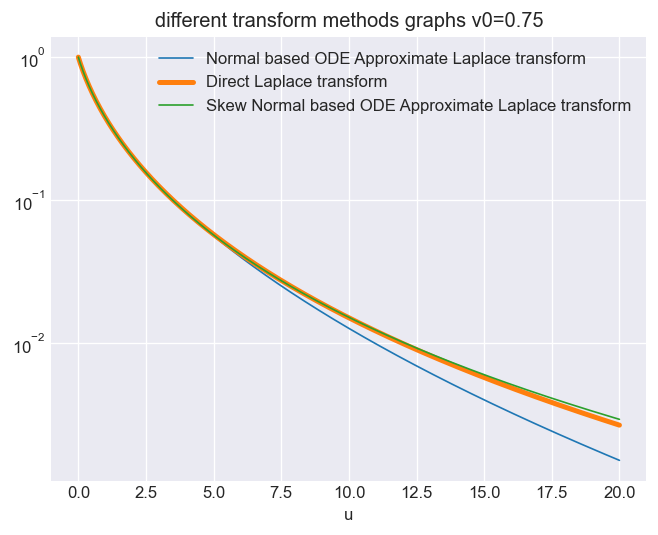

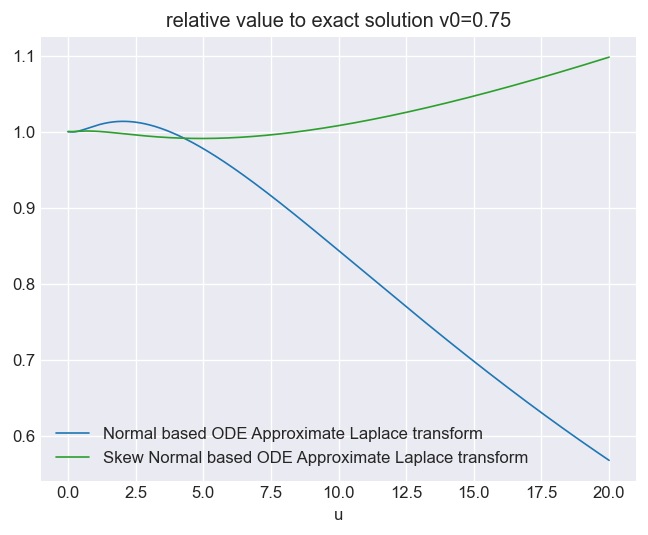

In [36]:
direct=LaplTrLNFastD(u_r,v0)
skew_normal=LaplTrLNODESkewNormal(u_r,v0)
fig, ax = plt.subplots(dpi=120)
plt.title(f'different transform methods graphs v0={v0}')

plt.plot(u_r,LaplTrLNODE2(u_r,v0),color='C0',linewidth=1, label=f'Normal based ODE Approximate Laplace transform ')
plt.plot(u_r,direct, linewidth=3, color='C1',label=f'Direct Laplace transform')
plt.plot(u_r,skew_normal,linewidth=1, color='C2',label=f'Skew Normal based ODE Approximate Laplace transform')

plt.xlabel('u')
plt.yscale('log')
plt.legend(loc='upper right')
plt.show()

fig, ax = plt.subplots(dpi=120)
plt.title(f'relative value to exact solution v0={v0}')
plt.plot(u_r,LaplTrLNODE2(u_r,v0)/direct,linewidth=1,color='C0', label=f'Normal based ODE Approximate Laplace transform')
plt.plot(u_r,skew_normal/direct,linewidth=1,color='C2', label=f'Skew Normal based ODE Approximate Laplace transform')

plt.xlabel('u')
plt.legend(loc='lower left')
plt.show()


Indeed, the approximation becomes better! We can move forward and take some distribution with 4,5,6... parameters.

### All we need is MGF
Important observation is: we don't need a distribution actually, only MGF. The interesting thing is that the MGF doesn't need to be a valid MGF for some distribution. We can take for exaple
$$\mathcal{M}(z)=(1+pz)\exp(\mu z+\frac{vz^2}{2})=(1+pz)\mathcal{M}_N(z),$$
where $\mathcal{M}_N(z)$ is MGF for the normal distribution $N(\mu,v)$. Its approriate PDF would be
$$\left(1+\frac{p(y-\mu)}{v}\right)f_N(y),$$
where $f_N(y)$ is the PDF for $N(\mu,v)$. It is obvious that for any $p,\mu, v$ , some $y$ exists that makes the first term  negative.

In [37]:
nonvalidMGF=(1+p*z)*sp.exp(z*μ + z**2*v/2)
nonvalidMGF

In [38]:
nonvalid_rm=RMgenerator(nonvalidMGF)
[nonvalid_rm(1),CM(nonvalid_rm,2),CM(nonvalid_rm,3)]

Parameters from moments:
$$p=\sqrt[3]{\frac{c_3}{2}}$$
$$v=c_2+p^2$$
$$\mu=m_1-p$$

In [39]:
dL=DCM(nonvalidMGF,0)
print("code:",dL)
prepend_latex("\\frac{dL}{du}=",dL)


code: -(p + 1)*exp(v/2 + μ)


<IPython.core.display.Math object>

In [40]:
dm1=DCM(nonvalidMGF,1)
print("code:",dm1)
prepend_latex("\\frac{dm_1}{du}=",dm1)

code: (p**2 - p*v - v)*exp(v/2 + μ)


<IPython.core.display.Math object>

In [41]:
dc1=DCM(nonvalidMGF,2)
print("code:",dc1)
prepend_latex("\\frac{dc_1}{du}=",dc1)

code: (-2*p**3 + 2*p**2*v - p*v**2 - v**2)*exp(v/2 + μ)


<IPython.core.display.Math object>

In [42]:
dc2=DCM(nonvalidMGF,3)
print("code:",dc2)
prepend_latex("\\frac{dc_2}{du}=",dc2)

code: (6*p**4 - 6*p**3*v + 3*p**2*v**2 - p*v**3 - v**3)*exp(v/2 + μ)


<IPython.core.display.Math object>

In [43]:
def LaplTrLNODENonvalidMGF(u,v0):# u must start from 0
    def ode(y,t):
        _,m1,c2,c3=y
        p=np.cbrt(0.5*c3)
        v=c2+p**2
        mu=m1-p
        
        M=np.exp(mu+0.5*v)
        
        dm1=(p**2 - p*v - v)*M
        dc2=(-2*p**3 + 2*p**2*v - p*v**2 - v**2)*M 
        dc3=(6*p**4 - 6*p**3*v + 3*p**2*v**2 - p*v**3 - v**3)*M
        
        return [-(p+1)*M,dm1,dc2,dc3]
    L,_,_,_=odeint(ode,[0.0,0.0,v0,0.0],u).T
    S=np.exp(L)
    return S

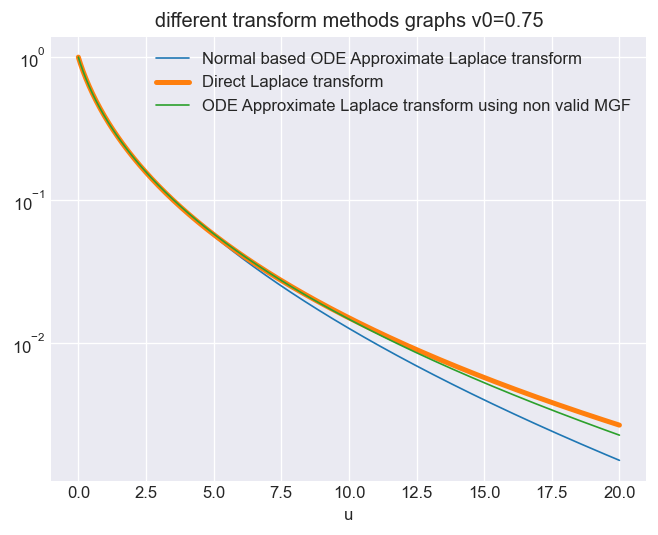

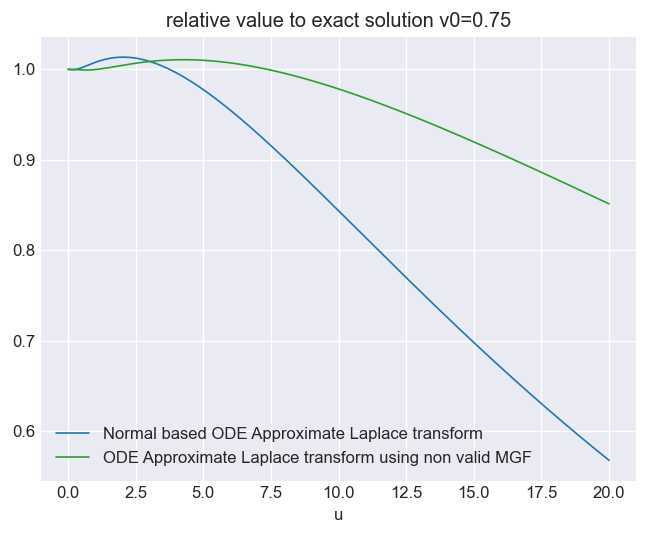

In [44]:
direct=LaplTrLNFastD(u_r,v0)
nonvalid=LaplTrLNODENonvalidMGF(u_r,v0)
normal=LaplTrLNODE2(u_r,v0)
fig, ax = plt.subplots(dpi=120)
plt.title(f'different transform methods graphs v0={v0}')

plt.plot(u_r,normal,linewidth=1,color='C0', label=f'Normal based ODE Approximate Laplace transform ')
plt.plot(u_r,direct, linewidth=3, color='C1', label=f'Direct Laplace transform')
plt.plot(u_r,nonvalid,linewidth=1, color='C2', label=f'ODE Approximate Laplace transform using non valid MGF')

plt.xlabel('u')
plt.yscale('log')
plt.legend(loc='upper right')
plt.show()

fig, ax = plt.subplots(dpi=120)
plt.title(f'relative value to exact solution v0={v0}')
plt.plot(u_r,normal/direct,linewidth=1,color='C0', label=f'Normal based ODE Approximate Laplace transform')
plt.plot(u_r,nonvalid/direct,linewidth=1,color='C2', label=f'ODE Approximate Laplace transform using non valid MGF')

plt.xlabel('u')
plt.legend(loc='lower left')
plt.show()

Look at the graphs! Non valid MGF is working!

That way we can get a stable MGF function with a lot of parameters and don't actually care much about whether it is valid MGF or not (though valid MGF is preferable). Next section a family of MGF's 
$$\mathcal{M}_i(z)=\exp\left(\sum_{k=1}^ip_k\frac{z^k}{k}\right),\,\,\,i=2...\infty$$
is used. If we take $\mathcal{M}_i(z)$ and set $p_1=\mu$, $p_2=v$, $p_k=0$ for $k=3..i$ it would be just MGF for the normal distribution $\exp(\mu z+vz^2/2)$.